El siguiente archivo es la respuesta a las preguntas, tanto teóricas como prácticas, solicitadas en el Trabajo Final. La sección de preguntas prácticas se complementa a su vez con el archivo `6_Analisis resultados.ipynb` donde se pueden visualizar los resultados de las modificaciones implementadas junto con algúnas conclusiones.

# 1. Dataset y Preprocesamiento

**- ¿Por qué es necesario redimensionar las imágenes a un tamaño fijo para una MLP?**



Al crear un modelo MPL con capas lineales, antes de entrenar, definimos un número fijo de entradas ya que aprenden pesos fijos para cada posición del vector que se irán actualizando, para cada neurona. Si el input son imágenes de distintas dimensiones, después del `flatten` tendríamos vectores de diferente tamaño y obtendríamos un error de dimension porque no tendríamos coincidencia de los pesos de la primera capa que siempre espera un tamaño fijo.


**- ¿Qué ventajas ofrece Albumentations frente a otras librerías de transformación como `torchvision.transforms`?**

Albumentations es una librería que nos permite hacer probabilísticamente transformaciónes de imágenes como técnica de data agumentation y cuenta con una documentación bien detallada con varios ejemplos para aprender a usar sus funciones. Esta es una técnica de regularización para que el modelo generalaice mejor y reducir el riesgo de overfitting.\
Contiene funciones básicas como rotación, traslación y normalización pero además posee otras funcionalidades más complejas que permiten distorsionar la información para generar nuevas entradas como . Además, esta librería no solo funciona con simples imágenes en 2D si no que también permite trabajar con imágenes en 3D (como el caso de las imágenes médicas) y con videos. 

**- ¿Qué hace `A.Normalize()`? ¿Por qué es importante antes de entrenar una red?**

`A.Normalize()` es una transformación de Albumentations que aplica varias técnicas para normalizar los valores de sus pixeles antes de ingresarlos a la red. La técnica de normalización específica (standard, image, image_per_channel, min_max, min_max_per_channel) puede seleccionarse con el parámetro normalization. Esta transformación convierte los valores de los píxeles, que pueden ir de 0 a 255, a una distribución normal al rededor del cero para cada canal. En el caso de la standard se aplica: `img = (img - mean) / std`. Esto favorece al modelo ya que las entradas quedan en una escala consistente y evita que ciertos canales dominen el aprendizaje por tener escalas más grandes.

**- ¿Por qué convertimos las imágenes a `ToTensorV2()` al final de la pipeline?**

Este es el último paso de la data aumentation y lo debemos hacer porque Albumentations trabaja con imágenes como numpy arrays pero nosotros para entrenar la red en PyTorch necesitamos de tensores, entonces con esa línea de código logramos convertir el array de la imágen después de sus respectivas transformaciones en el formato correcto para poder entrenar la red.

# 2. Arquitectura del Modelo

**- ¿Por qué usamos una red MLP en lugar de una CNN aquí? ¿Qué limitaciones tiene?**

Para la clasificación y procesamiento de imágenes una CNN suele ser la solución más elegída. Si bien el MLP se trata de un modelo más simple y fácil de implementar, no es una buena estrategia para la clasificación y análisis de imagenes dado que estas tiene patrones espaciales que la caracterizan (como su textura o bordes específicos) que en este caso, al convertirlo en un vector 1D después del ´flatten´, perdemos esa información estructural que puede ser importante en el caso de querer detectar por ejemplo anomalías en la piel o en muchos casos médicos. Por lo que no tiene mucho sentido esta estrategia.

**- ¿Qué hace la capa `Flatten()` al principio de la red?**

La capa ´flatten()´ se encarga de convertir la imágen que está en 2D y varios canales (por lo general 3: R,G,B) en un vector unidimensional ya que al usar un MLP, las capas lineares solo admiten vectores de entrada. En nuestro caso, al trabajar con imágenes de 64x64 en los tres canales, la imagen después del flatten resulta en un vector de 64x64x3 elementos, es decir 12.288 elementos.

**- ¿Qué función de activación se usó? ¿Por qué no usamos `Sigmoid` o `Tanh`?**

En el modelo simple se implementó la función de activación ReLU, con la forma convencional de una rampa que toma el valor 0 si la entrada x es negativa y lo mantiene igual si es positiva. Esta es la función estándar para redes neuronales porque, además de ser simple de implementar, evita el problema del "vanishing gradient".\
Este problema ocurre cuando los gradientes se vuelven muy pequeños impidiendo que los pesos se actualicen correctamente, es decir, la red deja de aprender. Al usar funciones como Sigmoid y Tanh, cuyas derivadas son menores a 1, el vanishing gradient es un problema. Al propagarse hacia atrás a través de muchas capas, esas derivadas se multiplican y se achican más en cada paso, haciendo que los gradientes se desvanezcan.

**- ¿Qué parámetro del modelo deberíamos cambiar si aumentamos el tamaño de entrada de la imagen?**

Si aumentamos el tamaño de la imagen de entrada, deberíamos modificar el `input_size=64*64*3` que representa la nueva cantidad de elementos que componenen al vector de 1D después de la capa de flatten para poder trabajar con la capa linear del MLP. Otra opción es, en el caso de tener imágenes de mayor tamaño y querer trabajar con menos elementos, podemos redimensionar la imágen.

# 3. Entrenamiento y Optimización

**- ¿Qué hace `optimizer.zero_grad()`?**

La función `optimizer.zero_grad()` en PyTorch se usa para reiniciar (poner en cero) los gradientes acumulados de todos los parámetros del modelo antes de calcular los nuevos gradientes en el paso de backpropagation. Esto es necesario para evitar acumular el gradiente de los cálculos anteriores en el nuevo paso.

**- ¿Por qué usamos `CrossEntropyLoss()` en este caso?**

Usamos `CrossEntropyLoss()` porque estamos trabajando con una clasificación multiclase, por lo que queremos que el modelo a la salida entregue una probabilidad de pertenencia para cada clase. Aunque el MLP termina con una capa de logits (valores sin normalizar), esta función aplica internamente softmax y calcula la pérdida de forma estable. Además, la entropía cruzada mide qué tan lejos está la predicción de la clase verdadera, cuanto más cerca esté la probabilidad asignada a la clase correcta de 1, menor será la pérdida.

**- ¿Cómo afecta la elección del tamaño de batch (`batch_size`) al entrenamiento?**

El batch size (BS) es la cantidad de datos que se procesan en la red, antes de ajustar los pesos por backpropagation. Lo que se hace es dividir al conjunto de datos totales del entrenamiento en N grupos con una cantidad BS de datos, y el modelo va a procesar cada batch hasta cubrir todos los datos (1 epoch). Esto es un hiperparámetro que hay que ajustar dado que afecta principalmente la dinámica del modelo ya que determina la frecuencia de actualización de pesos y la capcaidad de generalización del modelo. Un BS grande permite actualizaciones más estables y acelera el entrenamiento pero se puede perder generalización si es muy grande, mientras que un BS pequeño permite actualizaciones más frecuentes y ruidosas, tiene mejor capacidad de generalización pero es más lento por época (tarda mas en entrenar con todos los datos).

**- ¿Qué pasaría si no usamos `model.eval()` durante la validación?**

`model.eval()` se utiliza durante etapa de inferencia y validación. Funciona deshabilitando comportamientos específicos del entrenamiento y utilizando los parámetros aprendidos para obtener resultados consistentes. Por ejemplo, si la red incluye dropout, en entrenamiento es una herramienta muy útil contra el overfitting, ya que al apagar neuronas aleatoriamente hace que neuronas con pesos pequeños ganen protagonismo. Por otro lado, durante la validación, no apaga neuronas ya que se busca evaluar el comportamiento de toda la red.

# 4. Validación y Evaluación

**- ¿Qué significa una accuracy del 70% en validación pero 90% en entrenamiento?**

El *accuracy* es una métrica que evalúa el porcentaje de predicciones correctas (TP+TN/all data). Esta métrica es fácil de interpretar pero no es siempre la más útil, específicamente en el caso de clasificaciones binareas desbalanceadas.\
Tener un rendimiento tan alto en entrenamiento y sustancialmente más bajo en validación (un 20% menos) sugiere que estamos en presencia de un caso de *overfitting*. En este caso el modelo se ajusta demasiado bien a la distribución de datos de entrenamiento (aprende el patrón o detalles específicos) y deja de generalizar bien, y es por eso que al presentarle datos nuevos el desempeño es tanto peor.

**- ¿Qué otras métricas podrían ser más relevantes que accuracy en un problema real?**

El "accuracy" ya sea del train o de la validación no siempre reflejan el verdadero rendimiento de un modelo, especialmente en casos con clases desbalanceadas, por lo tanto puede ser relevante complementarlo con otras métricas como la loss o función de perdida, que permite ver la correspondencia 1 a 1 entre la estimación y la anotación, se usa para visualizar como se confunde el modelo en el entrenamiento y validación.

**- ¿Qué información útil nos da una matriz de confusión que no nos da la accuracy?**

La matriz de confusión muestra, de manera visual, como fue la distribución final de las salidas de la red en las diferentes clases con respecto a las anotaciones. En la diagonal principal tenemos la cantidad de elementos que fueron correctamente clasificados en cada clase y por fuera de la diagonal tenemos los errores de clasificación. Esto permite identificar qué clases están generando más confusión para el modelo y ver el desempeño del modelo en cada clase, cosa que con el accuracy no podemos ver ya que mide el total de verdaderos positivos sobre el total.

**- En el reporte de clasificación, ¿qué representan `precision`, `recall` y `f1-score`?**

- **Precision**: indica la proporción de predicciones positivas que fueron correctas. Un modelo con alta precisión minimiza falsos positivos, bueno si es que tienen un alto costo.
- **Recall**: mide la proporción de los casos positivos reales que fueron correctamente detectados por el modelo. Importa cuando queremos maximizar los verdaderos positivos que detectamos.
- **F1 score**: Balance entre precisión y recall, relevante cuando el costo de los errores es similar para los falsos positivos y falsos negativos. Se usa mucho para analizar el rendimiento cuando las clsaes son desbalanceadas


# 5. TensorBoard y Logging


**- ¿Qué ventajas tiene usar TensorBoard durante el entrenamiento?**

Tensorboard permite visualizar en tiempo real la dinámica del entrenamiento a través de métricas como la loss, el accuracy, entre otros. Esta visualización facilita la detección de problemas como overfitting o underfitting, y ayuda a entender mejor el comportamiento del modelo frente a distintos ajustess. Además, nos permite llevar un registro organizado de cada run, para comparar mejor los resultado al variar diferentes hiperparámetos.


**- ¿Qué diferencias hay entre loguear `add_scalar`, `add_image` y `add_text`?**

Por medio de distintas funciones podemos loguear distintos tipos de resultados que vamos obteniendo al entrenar la red. En este caso `add_scalar` permite guardar valores numéricos que podrían ser las métricas (loss, accuracy); `add_image` es para guardar y visualizar graficos e imágenes. Por último, `add_text` permite registrar texto como comentarios, detalles o anotaciones, útil para documentar los resultados obtenidos.

**- ¿Por qué es útil guardar visualmente las imágenes de validación en TensorBoard?**

Guardar las imágenes de validación es útil porque podemos evaluar visualmente lo que el modelo hizo de manera cuantitativa. En si, el objetivo es encontrar el modelo que logra clasificar las imágenes de diagnóstico médico con mejor presición, por lo que la interpretación visual en este contexto es importante y sirve poder comparar de manera directa en qué imágenes falla más veces y ver si las predicciones desde otro punto de vista tienen sentido.

**- ¿Cómo se puede comparar el desempeño de distintos experimentos en TensorBoard?**

Para comparar el desempeño de distintos experimentos en TensorBoard, se pueden guardar los registros de cada entrenamiento, especificando un nombre que refleje los hiperparámetros utilizados (por ejemplo, tasa de aprendizaje o tamaño del batch). Luego, al ejecutar TensorBoard sobre la carpeta principal que contiene todos los experimentos, la interfaz detecta automáticamente las distintas ejecuciones y permite visualizar sus curvas de métricas en conjunto. De esta forma, es posible superponer gráficos de loss, accuracy u otras métricas y evaluar cuál configuración del modelo produjo mejores resultados. Esta funcionalidad resulta fundamental para el análisis comparativo y la toma de decisiones durante la etapa de ajuste del modelo.

# 6. Generalización y Transferencia

**- ¿Qué cambios habría que hacer si quisiéramos aplicar este mismo modelo a un dataset con 100 clases?**

En primer lugar, la última capa debería tener 100 neuronas en lugar de 10, esto es debido a que cada neurona de la última capa devuelve el score de pertenencia a una determinada clase. Con esto ya se puede re-entrenar la red (los pesos ya no serían los mismos) pero probablemente el modelo no sea lo suficientemente complej como para distinguir las 100 clases, por lo que habría que modificar la profundidad del mismo.

**- ¿Por qué una CNN suele ser más adecuada que una MLP para clasificación de imágenes?**

Como ya mencionamos antes, el MLP no es adecuado para clasificar imágenes dado que requiere que la entrada sea un vector 1D, y por lo tanto al hacerle este flatten perdemos la información espacial que caracteriza la imágen. Con una CNN, por otro lado, podemos ingresar a la red directamente con la imágen original

**- ¿Qué problema podríamos tener si entrenamos este modelo con muy pocas imágenes por clase?**

Si entrenamos el modelo de esta forma es probable que memorice las pocas imágenes de entrenamiento en lugar de aprender patrones generales, provocando que no generalice bien al ver entradas nuevas.
Además, con muy pocos ejemplos, es probable que las imágenes no representen bien la variabilidad natural de esa clase (cambios de iluminación, ángulos, escalas, fondos, etc.). Como resultado, el modelo aprenderá una versión sesgada de cada clase, lo que reduce su capacidad para reconocer correctamente nuevas instancias de esa misma clase. El data augmentation podría ayudar un poco con este problema.

**- ¿Cómo podríamos adaptar este pipeline para imágenes en escala de grises?**

El pipeline en general sería el mismo, una imagen en escala de grises tiene profundidad de pixel igual a 1, mientras que a color 3. Por lo tanto, la única modificación es que el input size pasa a ser un tercio del original.

# 7. Regularización

**- ¿Qué es la regularización en el contexto del entrenamiento de redes neuronales?**


La regularización hace referencia a las técnicas que se pueden emplear, con diferentes hiperarametros ajustables, para evitar el overfitting y asegurar que la red generalice bien; ya que en redes neuronales el primer problema es que el modelo converja a una solución y el segundo es que esa solución generalice bien la realidad. Esto emplea restircciones o penalizaciones en el entrenamiento, que es cuando la red está aprendiendo, para generar un modelo robusto y que no solamente memorice los datos.


**- ¿Cuál es la diferencia entre `Dropout` y regularización `L2` (weight decay)?**

La diferencia entre ambas técnicas es que dropout inactiva neuronas al azar, esto busca que se formen nuevos caminos con mas protagonismo. Por otro lado weight decay agrega un terimno de pensalizacion en la funcion de costo. Este termino es la norma L2 de los pesos multiplicado por un factor $\lambda$ (hiperparámetro) que modula su importancia. De esta forma se penalizan aquellas neuronas con pesos de modulo alto y se trabaja en la zona central de la funación de activación

**- ¿Qué es `BatchNorm` y cómo ayuda a estabilizar el entrenamiento?**

Batch Normalization es un técnica de agilización de entrenamiento que se utiliza para escalar un batch de salida de cada capa según la media y el desvio de ese conjunto de datos en paralelo. Esto soluciona el problema del Internal Covariate Shift (cambio en la distribución de salida de las activaciones de la red porque al sumar capas se mueven hacia los extremos y se encaja el proceso), ya que al normalizar la salida de cada capa antes de pasar a la siguiente, lo volvemos a centrar con una distribución normal al rededor del cero.

**- ¿Cómo se relaciona `BatchNorm` con la velocidad de convergencia?**

Además de trabajr en batches, al normalizar cada capa, logramos tener entradas más estables lo que le permite al modelo utilizar un learning rate mayor sin riesgo de que explote y logra aprender más rápido. Además, al meter un poco de ruido, evitamos mínimos locales que pueden dar lugar al overfiting.

**- ¿Puede `BatchNorm` actuar como regularizador? ¿Por qué?**

Dado que BatchNorm promedia por mini-batch y no el total de observaciones, el cálculo de
la media y varianza es ruidoso. Esto tiene un leve efecto de regularización ya
que es como si cada nuevo batch se moviera levemente respecto al anterior y entonces el entrenamiento resulta más estable.

**- ¿Qué efectos visuales podrías observar en TensorBoard si hay overfitting?**

El overfitting es visile en el gráfico de accuracy. Se puede ver como al principio del entrenamiento tanto el accuracy de train como validacion mejoran, pero despues de un tiempo divergen y el accuracy de validacion empeora notablemente. 
Otra forma de visualizar overfitting es con el histograma de pesos, un indicio es si se tiene un alto numero de neuronas con pesos muy grandes en modulo.

**- ¿Cómo ayuda la regularización a mejorar la generalización del modelo?**

La regularización ayuda a la generalizacion del modelo impidiendo que este memorice el dataset de entrenamiento. Esto se hace principalmente agregando ruido en la etapa de entrenamiento (dropout o data augmentation), o imponiendo restricciones explicitas en la dinamica de entranamiento (weigth decay, early stopping). De esta forma se minimiza el riesgo de overfitting.

## Preguntas Prácticas

**- ¿Qué efecto tuvo `BatchNorm` en la estabilidad y velocidad del entrenamiento?**

Se puede ver como en la gran mayoria de los casos el entrenamiento fue mas rapido, habiendo una diferencia notable en el tiempo de entrenamiento y en la cantidad de epocas que entrenó.

**- ¿Cambió la performance de validación al combinar `BatchNorm` con `Dropout`?**

Si bien muchas veces no se recomienda utilizar Batch Normalization a la vez que Dropout porque pueden interferir entre sí, en este caso se ve que los mejores modelos se obtuvieron con esta combinacíon. Sin embargo las mejoras no son significativas, por lo que tal vez no es convenible sumarle esa complejidad al problema.

Haciendo un análisis de las causas de esto, más allá de que un MLP no es el mejor modelo para analizar imágenes y más aún si es que tienen tantos patrones espaciales como es en el caso del set de datos proporcionado, creemos que las mejoras se pueden ver ya que se optó por incluir dropout después de hacer la normalización por lo que el ruido de apagar neuronas no interfiere en el calculo anterior del batch norm, y esto puede ayudar a generalizar mejor. 

**- ¿Qué combinación de regularizadores dio mejores resultados en tus pruebas?**


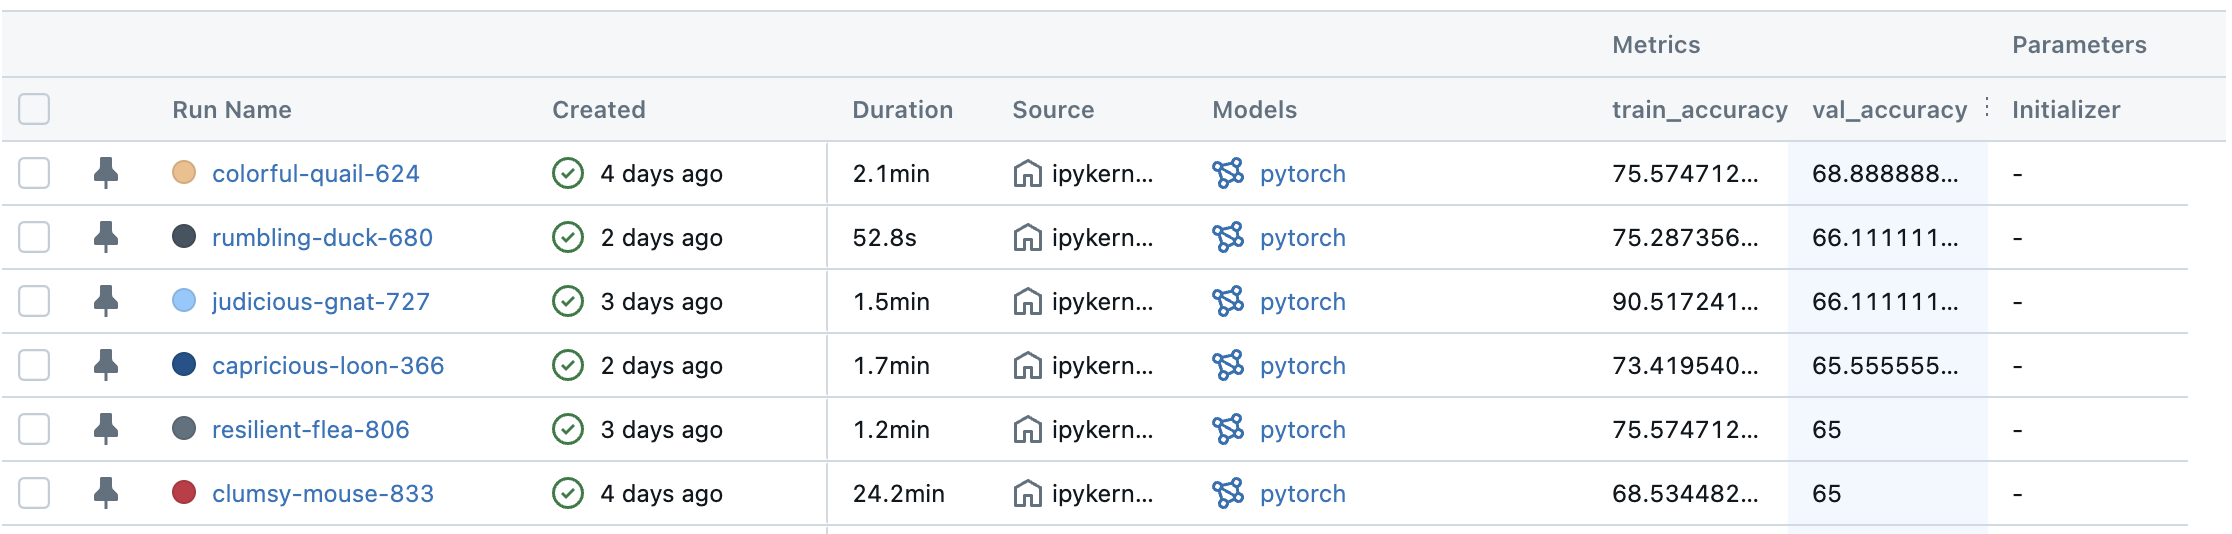
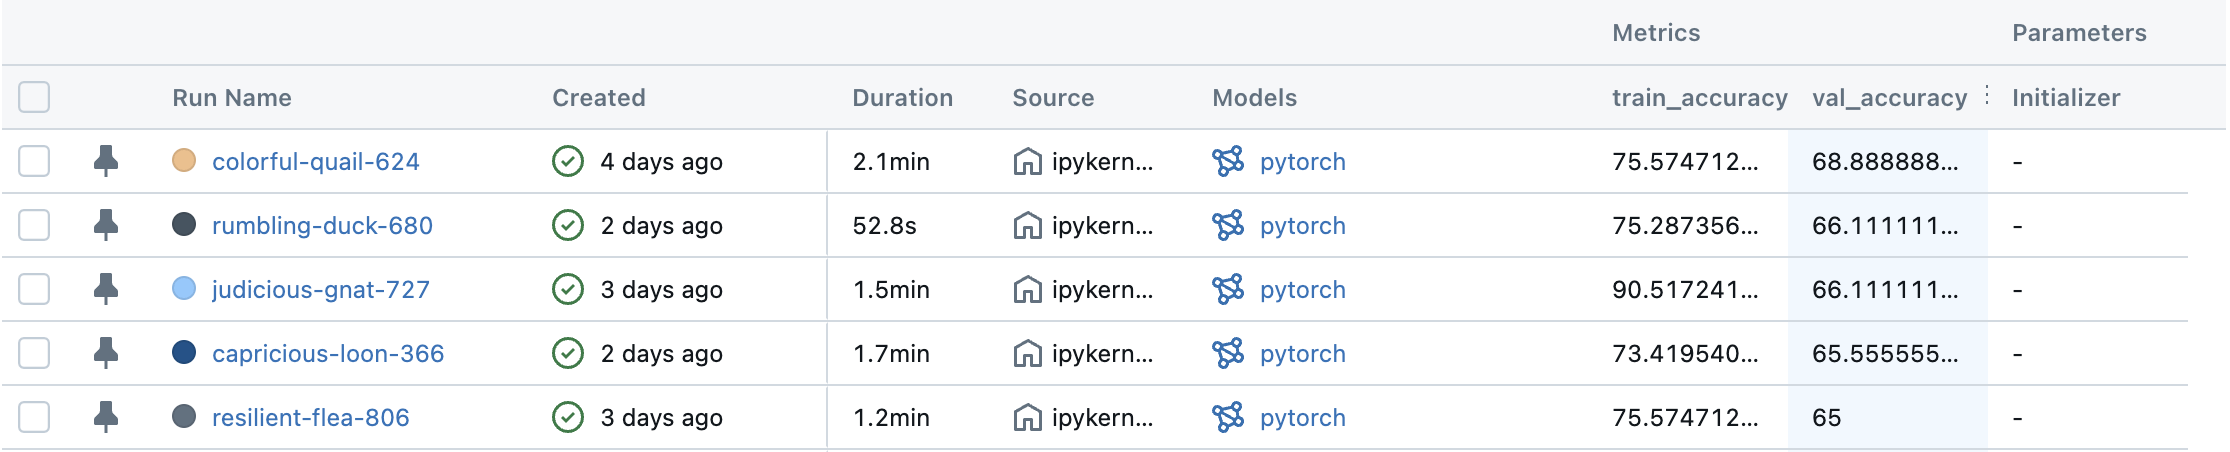

Se puede ver que estos fueron los modelos con mejor accuracy en el set de validación, sin embargo al comparar con el accuracy del train se puede ver que para el 3er modelo tenemos overfitting (el modelo esta copiando train más que aprendiendo a generalizar), por lo que no es un buen modelo. Con los 5 restantes analizamos la combinación de HP. Cabe destacar que no se espera un alto rendimiento porque estamos usando un MLP para clasificar imágenes complejas, por lo que es aceptable que la mejor validation accuracy sea un 68%.

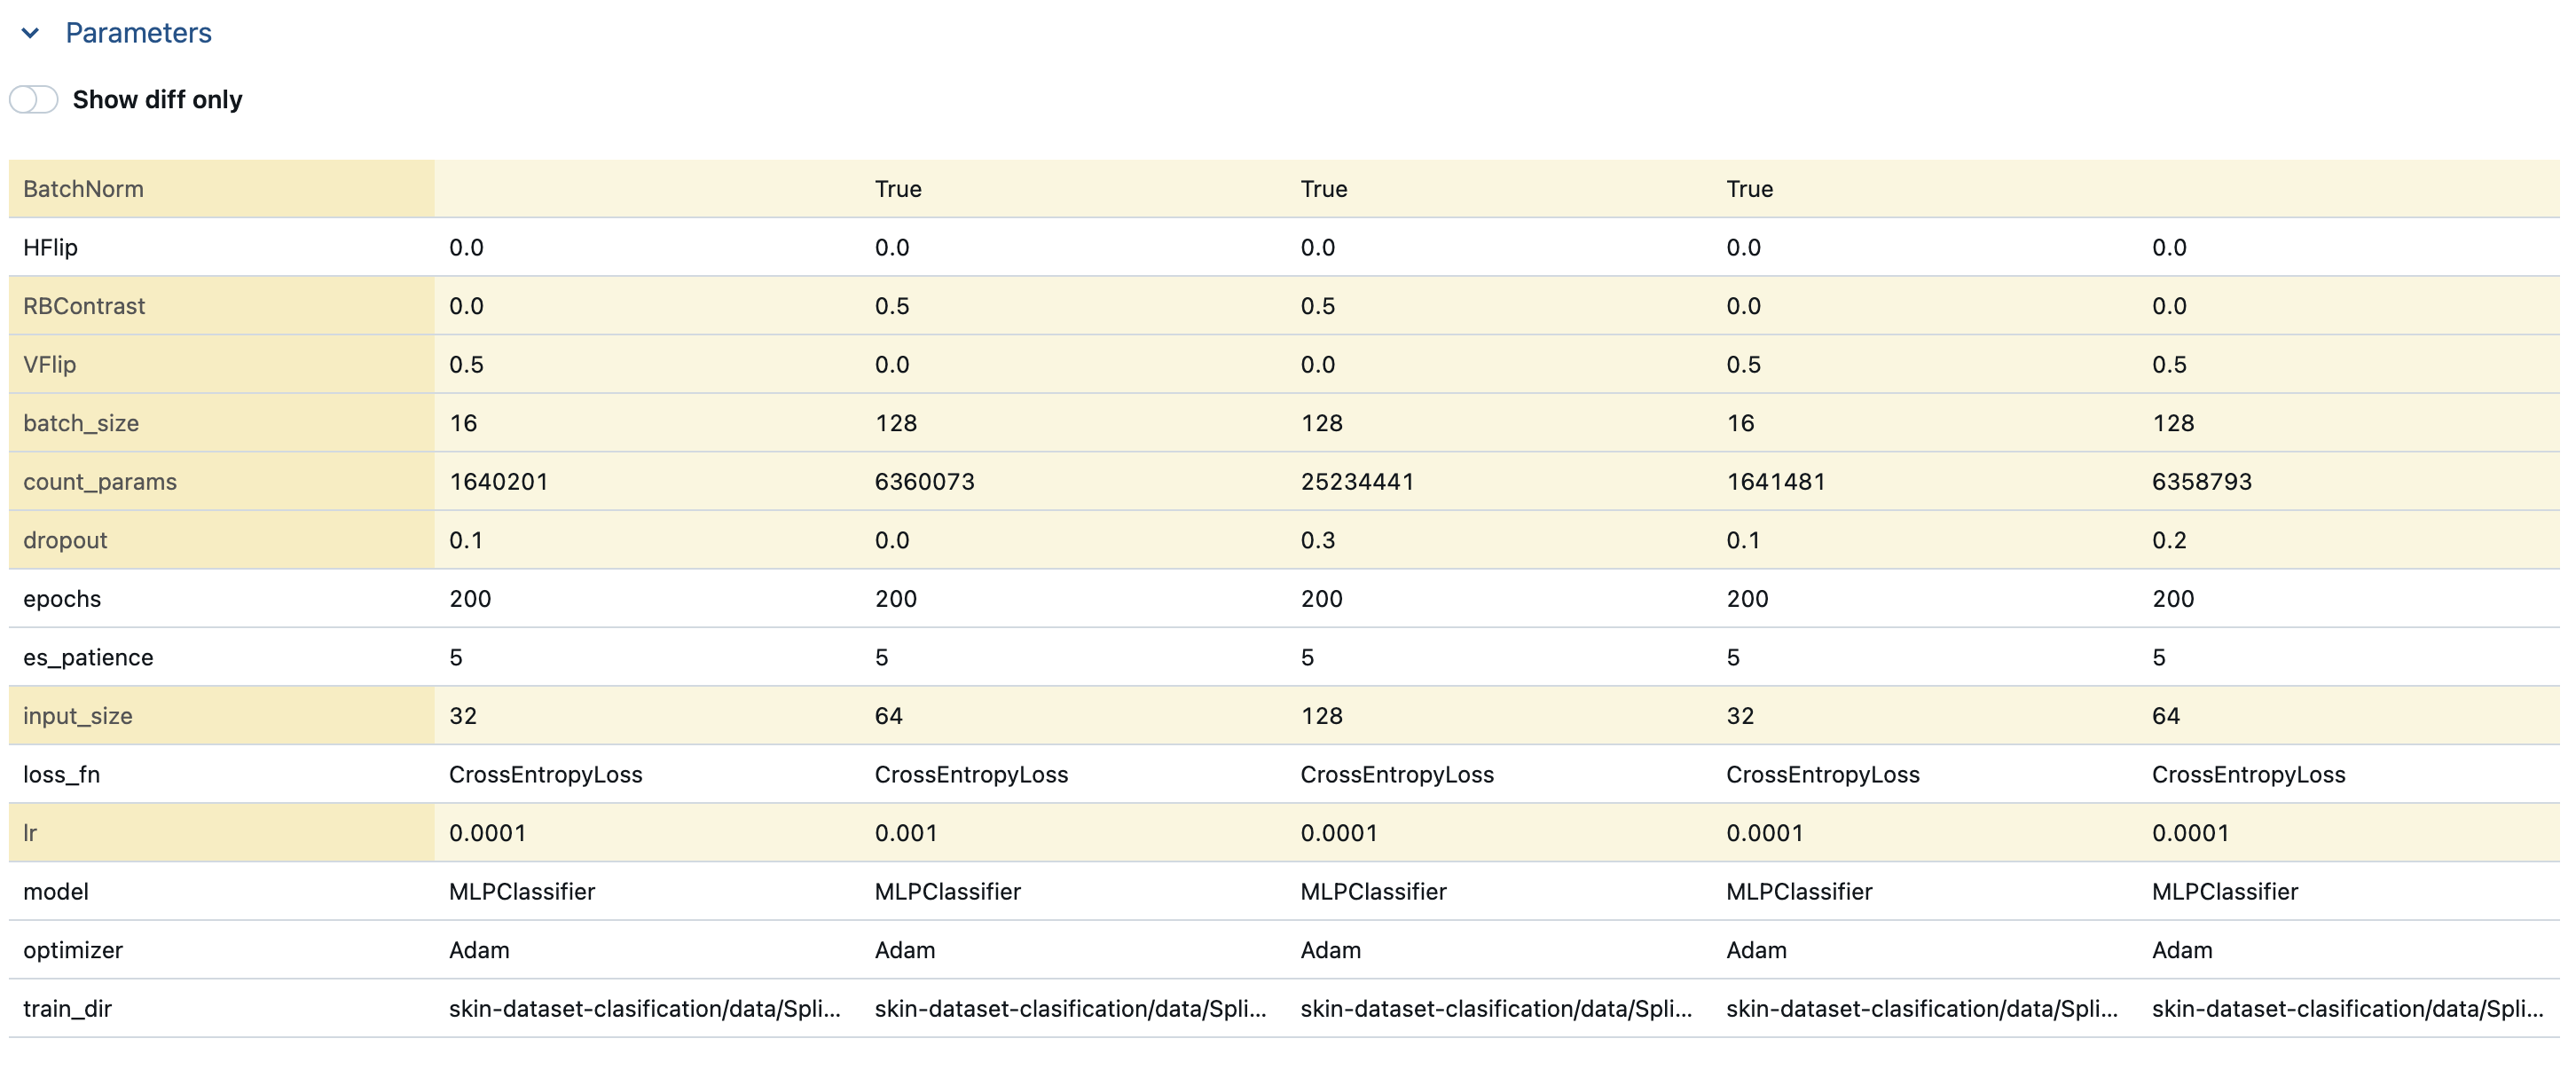

aca observamos la combinación de HP para cada modelo, se puede ver (en amarillo) los parametros en los que difieren y en blanco lo que se mantiene constante. En este caso vemos que los mejores modelos no tenian data aumentation con flips horizontales (implicando que girar la imagen horizontalmente agrega ruido que confunde al modelo en lugar de ayudarlo a clasificar y generalizar). Para el resto de los HP varían pero hay hay algunos casos que se reptien (como batch size que vale 16 0 128) y también vemos que hay modelos con y sin dropot o batchnorm e incluso con una combinación de ambas. Por lo tanto no hay un patrón que se repita en todos los modelos.

**- ¿Notaste cambios en la loss de entrenamiento al usar `BatchNorm`?**

Analizando los graficos de train loss, se puede ver que en los modelos con batch normalization muestran curvas mas suaves, con descensos graduales (síntomas de entrenamiento saludables) y que además se estabilizan en valores mas bajos que aquellos modelos sin este hiperparametro. 

# 8. Inicialización de Parámetros

**- ¿Por qué es importante la inicialización de los pesos en una red neuronal?**

Inicializar los pesos en una red neuronal es importante porque determina las primeras etapas del entrenamiento. Una mala inicialización puede causar vanishing o exploding gradients, lo que puede dificultar o estancar el entrenamiento. Por otro lado, una buena inicialización rompe la simetría entre neuronas, permitiendo que cada una aprenda funciones distintas.

**- ¿Qué podría ocurrir si todos los pesos se inicializan con el mismo valor?**

Si todos los pesos se inicializan con el mismo valor, la red no puede aprender correctamente, ya que todas las neuronas tendrian el mismo output y recibirían el mismo gradiente. Esto mantiene la simetría entre ellas, impidiendo que aprendan representaciones distintas.

**- ¿Cuál es la diferencia entre las inicializaciones de Xavier (Glorot) y He?**

Glorot esta pensado para funciones de activación simétricas alrededor de cero, como tanh o sigmoid. La ventaja de esta inicialización es que mantiene la varianza constante entre las activaciones y los gradientes a través de las capas.

Para una neurona con fan_in entradas y fan_out salidas se definen:

Glorot uniforme: $W \sim \mathcal{U}\left(-\sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}, \ \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}} \right)$

Glorot normal: $W \sim \mathcal{N}\left(0, \ \frac{2}{\text{fan\_in} + \text{fan\_out}} \right)$

Por otro lado, la inicialización He fue diseñada específicamente para la función de activación ReLu y sus variantes. Busca compensar la pérdida de varianza por ReLU

Las distribuciones son las siguientes:

He uniforme: $W \sim \mathcal{U}\left(-\sqrt{\frac{6}{\text{fan\_in}}}, \ \sqrt{\frac{6}{\text{fan\_in}}} \right)$

He Normal: $W \sim \mathcal{N}\left(0, \ \frac{2}{\text{fan\_in}} \right)$


**- ¿Por qué en una red con ReLU suele usarse la inicialización de He?**

La funcion ReLU(x)=max(0,x), esto anula todas las activaciones negativas. Si la entrada tiene distribución simétrica alrededor de cero, el 50% de las activaciones serán cero (en promedio). Eso hace que, a medida que se avanza por la red, las activaciones se vuelvan muy pequeñas, generandose una perdida en la varianza.
La inicialización He aumenta la varianza inicial (al doble) para que tras aplicar ReLU, la varianza de las activaciones se mantenga estable.


**- ¿Qué capas de una red requieren inicialización explícita y cuáles no?**

Todas las capas que tengan pesos entrenables, es decir que aprenden en el entrenamiento, requieren de una inizialización explícita.

## Preguntas prácticas:

**- ¿Qué diferencias notaste en la convergencia del modelo según la inicialización?**

Los modelos con Xavier o He presentaron una dinamica de entrenamiento mas saludables que los modelos con inicialización uniforme.
Los graficos de inicialización uniforme muestran una loss muy ruidosa y estabilizada en un valor alto. Además la mayoría de esos modelos tuvieron muy pocas epocas de entrebamiento y obtienen accuracy bajo.
Por otra parte, haciendo un análisis mas fino se puede notar como los modelos de Xavier presentan estos mismos defectos (a menor escala) si se los compara con los modelos con He. Esto era de esperarse, ya que se sabe que por lo general, la inicialización He es la que mejor funciona para las funciones de activación de la familia ReLu (y la inicializacion Xavier de este caso tamnbien es uniforme). 

**- ¿Alguna inicialización provocó inestabilidad (pérdida muy alta o NaNs)?**

La inicialización uniforme generó modelos con loss de validación muy elevada y entrenamientos muy cortos pero no NaNs. El código implementado está en analisis de resultados.
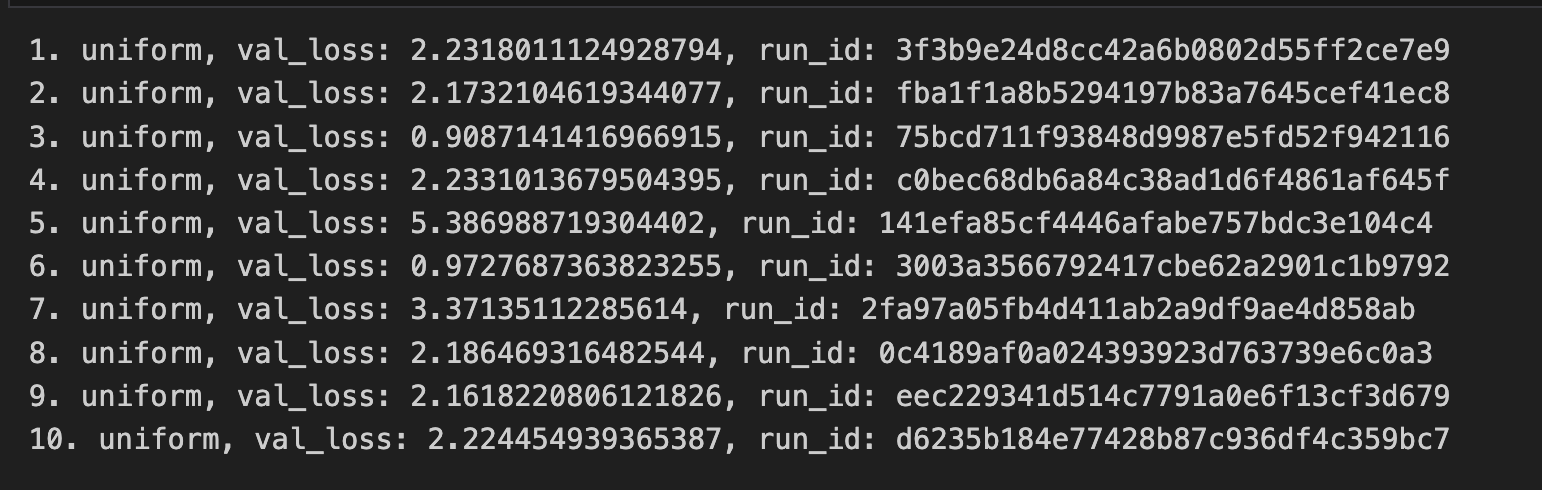

**- ¿Qué impacto tiene la inicialización sobre las métricas de validación?**

Analizando los graficos se puede concluir que el tipo de inicialización es un hiperparámetro clave que influye en el desempeño del modelo, ya que este define como será la dinámica del entrenamiento. Se puede ver que la gran mayoría de los modelos entrenados con los mismos inicializadores presentan resultados similares y ademas: Los mejores scores se obtuvieron con He, seguidos por Xavier con resultados bastante similares y finalmente aquellos con distribucion uniforme con métricas de validación muy pobres.

**- ¿Por qué `bias` se suele inicializar en cero?**

El bias permite realizar un desplazamiento en la función de activación para que se ajuste mejor a los datos, por lo que la red puede ajustar la salida incluso si todas las entradas son cero.
A diferencia de los pesos, que deben ser distintos para romper con la simetría, el bias suele iniciarse en cero para no sesgar a la red desde el inicio hacía una salida y la red lo irá ajustando el bias en el aprendizaje por backpropagation. Esto es posible ya que los pesos son aleatroios y por lo tanto cada neurona sigue tienendo la capacidad de aprender algo distinto.